<a href="https://colab.research.google.com/github/tg-bomze/Style-Transfer-Collection/blob/master/(Photo)_artistic_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">artistic-style-transfer</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [artistic-style-transfer](https://github.com/hnarayanan/artistic-style-transfer)

Article: [Convolutional neural networks for artistic style transfer](https://harishnarayanan.org/writing/artistic-style-transfer/)

Creator: **[Harish Narayanan](https://github.com/hnarayanan).**

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, нажмите на кнопку (куда указывает красная стрелка), после чего дождитесь завершения выполнения блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary components</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые компоненты</font></b>

!git clone https://github.com/hnarayanan/artistic-style-transfer.git
%cd artistic-style-transfer
!pip install -r requirements.txt
!pip install scipy==1.1

from __future__ import print_function

import time

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

import os
import io
import cv2
from PIL import Image
import imageio
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
from IPython.display import HTML
%matplotlib inline

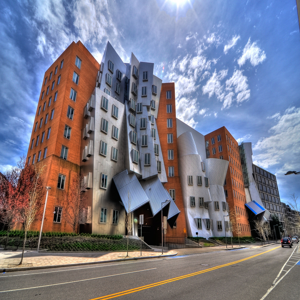

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload content image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить основное фото</font></b>

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
content_img = "content." + fn.split(".")[-1]
!mv -f $fn $content_img

im = Image.open(content_img)
(width_cont, height_cont) = im.size
content_img_max = max(width_cont, height_cont)
content_img_min = min(width_cont, height_cont)

display(Image.open(content_img).resize((300, 300)))

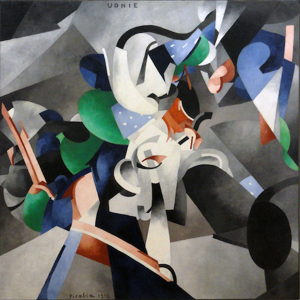

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload style image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить фото со стилем</font></b>

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
style_img = "style." + fn.split(".")[-1]
!mv -f $fn $style_img

im = Image.open(style_img)
(width_styl, height_styl) = im.size
style_img_max = max(width_styl, height_styl)
style_img_min = min(width_styl, height_styl)

display(Image.open(style_img).resize((300, 300)))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Style Transfer</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Перенести стиль из фото на видео</font></b>
%%time

content_image = Image.open(content_img)
content_image = content_image.resize((width_cont, height_cont))
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]
content_image = backend.variable(content_array)

style_image = Image.open(style_img)
style_image = style_image.resize((width_styl, height_styl))
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]
style_image = backend.variable(style_array)

combination_image = backend.placeholder((1, height_cont, width_cont, 3))
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
layers = dict([(layer.name, layer.output) for layer in model.layers])

iterations = 10 #@param {type:"slider", min:5, max:30, step:1}
#@markdown ---
content_weight = 0.025 #@param {type:"slider", min:0, max:1, step:0.025}
style_weight = 5.0 #@param {type:"slider", min:0, max:10, step:0.5}
total_variation_weight = 1.0
loss = backend.variable(0.)

def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height_cont * width_cont
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
  a = backend.square(x[:, :height_cont-1, :width_cont-1, :] - x[:, 1:, :width_cont-1, :])
  b = backend.square(x[:, :height_cont-1, :width_cont-1, :] - x[:, :height_cont-1, 1:, :])
  return backend.sum(backend.pow(a + b, 1.25))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + (content_weight * content_loss(content_image_features, combination_features))
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)
grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height_cont, width_cont, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()
x = np.random.uniform(0, 255, (1, height_cont, width_cont, 3)) - 128.

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

x = x.reshape((height_cont, width_cont, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')
result = Image.fromarray(x)
result.save('result.png')
result_img = "/content/artistic-style-transfer/result.png"

CPU times: user 1min 31s, sys: 47.6 s, total: 2min 18s
Wall time: 2min 1s


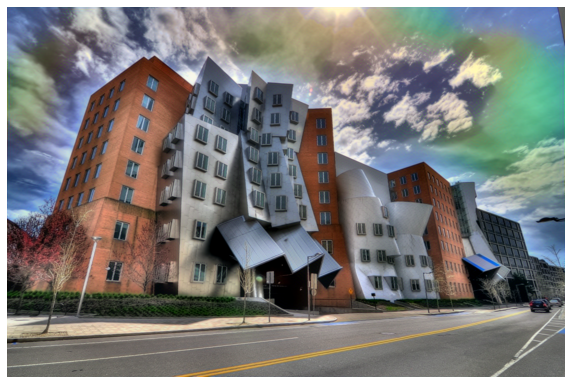

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Open the final image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Открыть итоговый результат</font></b>
fig = plt.figure(figsize=(10, 10))
img = plt.imread(result_img)
plt.axis('off')
plt.imshow(img)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download the final image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Скачать итоговый результат</font></b>
files.download(result_img)